In [2]:
import pandas as pd
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('PCPS_06-08-2023 20-05-34-68_timeSeries.csv')

In [4]:
print(df.columns)

Index(['Country Name', 'Country Code', 'Commodity Name', 'Commodity Code',
       'Unit Name', 'Unit Code', 'Attribute', '1990M1', '1990M2', '1990M3',
       ...
       '2022M9', '2022M10', '2022M11', '2022M12', '2023M1', '2023M2', '2023M3',
       '2023M4', '2023M5', 'Unnamed: 408'],
      dtype='object', length=409)


In [5]:
df.iloc[:1]

,Country Name,Country Code,Commodity Name,Commodity Code,Unit Name,Unit Code,Attribute,1990M1,1990M2,1990M3,...,2022M9,2022M10,2022M11,2022M12,2023M1,2023M2,2023M3,2023M4,2023M5,Unnamed: 408
0,World,1,Industrial Materials index,PINDU,Index,IX,Value,NaN,NaN,NaN,...,150.151534,145.460865,150.97663,161.980246,171.621298,179.16502,174.347289,168.590033,156.139228,NaN


In [6]:
#Выбираем параметр, который будем исследовать.
choose_com = "PPMETA"

#На сколько предсказываем
Ntest = 12

In [7]:
df["Country Name"].value_counts()
df["Unit Name"].value_counts()

# df["Commodity Name"].value_counts()

Index                                                     110
Percent Change over Previous Period                       110
Percent Change over Corresponding Period Previous Year    110
US Dollars                                                 82
Name: Unit Name, dtype: int64

In [8]:
df = df[df["Unit Name"] == "Index"]
df

,Country Name,Country Code,Commodity Name,Commodity Code,Unit Name,Unit Code,Attribute,1990M1,1990M2,1990M3,...,2022M9,2022M10,2022M11,2022M12,2023M1,2023M2,2023M3,2023M4,2023M5,Unnamed: 408
0,World,1,Industrial Materials index,PINDU,Index,IX,Value,NaN,NaN,NaN,...,150.151534,145.460865,150.976630,161.980246,171.621298,179.165020,174.347289,168.590033,156.139228,NaN
2,World,1,Precious Metals Price Index,PPMETA,Index,IX,Value,33.097764,33.701146,31.811295,...,137.062373,136.059120,140.510205,145.809430,152.783444,148.040839,151.807554,159.534115,158.514045,NaN
3,World,1,Non-Fuel index,PNFUEL,Index,IX,Value,NaN,NaN,NaN,...,143.881124,144.015105,147.299088,149.996762,154.542927,155.792541,156.037508,156.329009,150.735273,NaN
4,World,1,Metal index,PMETA,Index,IX,Value,NaN,NaN,NaN,...,165.864220,161.612637,169.005520,184.304374,198.819456,209.104578,203.581402,195.530358,178.184281,NaN
5,World,1,Agriculture,PAGRI,Index,IX,Value,NaN,NaN,NaN,...,131.306603,132.286616,131.888855,130.403176,131.703928,135.741229,138.246900,138.700522,135.389215,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,World,1,Coffee index,PCOFF,Index,IX,Value,51.646212,54.582653,61.218914,...,144.463432,131.389404,117.466192,116.359819,117.252118,128.698382,128.034671,135.392155,136.322908,NaN
396,World,1,"Coffee, Robustas",PCOFFROB,Index,IX,Value,57.009468,57.889660,65.089195,...,125.662523,116.244138,104.489146,104.308593,108.307935,117.317405,120.166063,130.430598,138.294422,NaN
405,World,1,Heating Oil,PHEATOIL,Index,IX,Value,57.463446,44.865313,45.231109,...,254.742986,324.275808,297.758251,229.481793,240.967927,205.831611,200.415900,189.440819,170.132725,NaN
407,World,1,Oats,POATS,Index,IX,Value,72.830421,69.972760,74.464928,...,202.370072,195.199742,198.971905,181.183543,186.367481,190.249366,179.646528,170.243527,166.440314,NaN


In [9]:
df2 = df.transpose()

In [10]:
df2

,0,2,3,4,5,13,21,24,26,29,...,376,378,383,388,390,395,396,405,407,411
Country Name,World,World,World,World,World,World,World,World,World,World,...,World,World,World,World,World,World,World,World,World,World
Country Code,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Commodity Name,Industrial Materials index,Precious Metals Price Index,Non-Fuel index,Metal index,Agriculture,Fertilizer,All Metals EX GOLD Index,Food index,Energy index,Natural gas index,...,Chromium,Manganese,Bananas,Orange,Wool index,Coffee index,"Coffee, Robustas",Heating Oil,Oats,Nickel
Commodity Code,PINDU,PPMETA,PNFUEL,PMETA,PAGRI,PFERT,PEXGMETA,PFOOD,PNRG,PNGAS,...,PCHROM,PMANGELE,PBANSOP,PORANG,PWOOL,PCOFF,PCOFFROB,PHEATOIL,POATS,PNICK
Unit Name,Index,Index,Index,Index,Index,Index,Index,Index,Index,Index,...,Index,Index,Index,Index,Index,Index,Index,Index,Index,Index
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023M2,179.16502,148.040839,155.792541,209.104578,135.741229,253.088422,201.981854,142.64378,201.718393,231.518007,...,134.908716,136.515018,167.066355,145.997266,100.260875,128.698382,117.317405,205.831611,190.249366,278.556031
2023M3,174.347289,151.807554,156.037508,203.581402,138.2469,224.879647,196.633343,146.184333,186.023155,197.485761,...,132.978512,141.140986,161.21042,151.593245,94.927498,128.034671,120.166063,200.4159,179.646528,242.711554
2023M4,168.590033,159.534115,156.329009,195.530358,138.700522,226.061644,191.008856,146.266441,192.368523,187.266901,...,128.04674,133.686201,165.344021,164.13812,93.217154,135.392155,130.430598,189.440819,170.243527,247.736903
2023M5,156.139228,158.514045,150.735273,178.184281,135.389215,220.335147,175.287014,142.059618,169.225914,150.936606,...,123.814737,132.292904,161.030699,160.752181,91.301839,136.322908,138.294422,170.132725,166.440314,230.686498


In [11]:
df3 = df2.drop(["Country Name", "Commodity Name", "Country Code", "Unit Name", "Unit Code", "Attribute"], axis = 0)

In [12]:
df3.columns = df3.iloc[0]

In [13]:
df4 = df3.drop(["Commodity Code"], axis = 0)

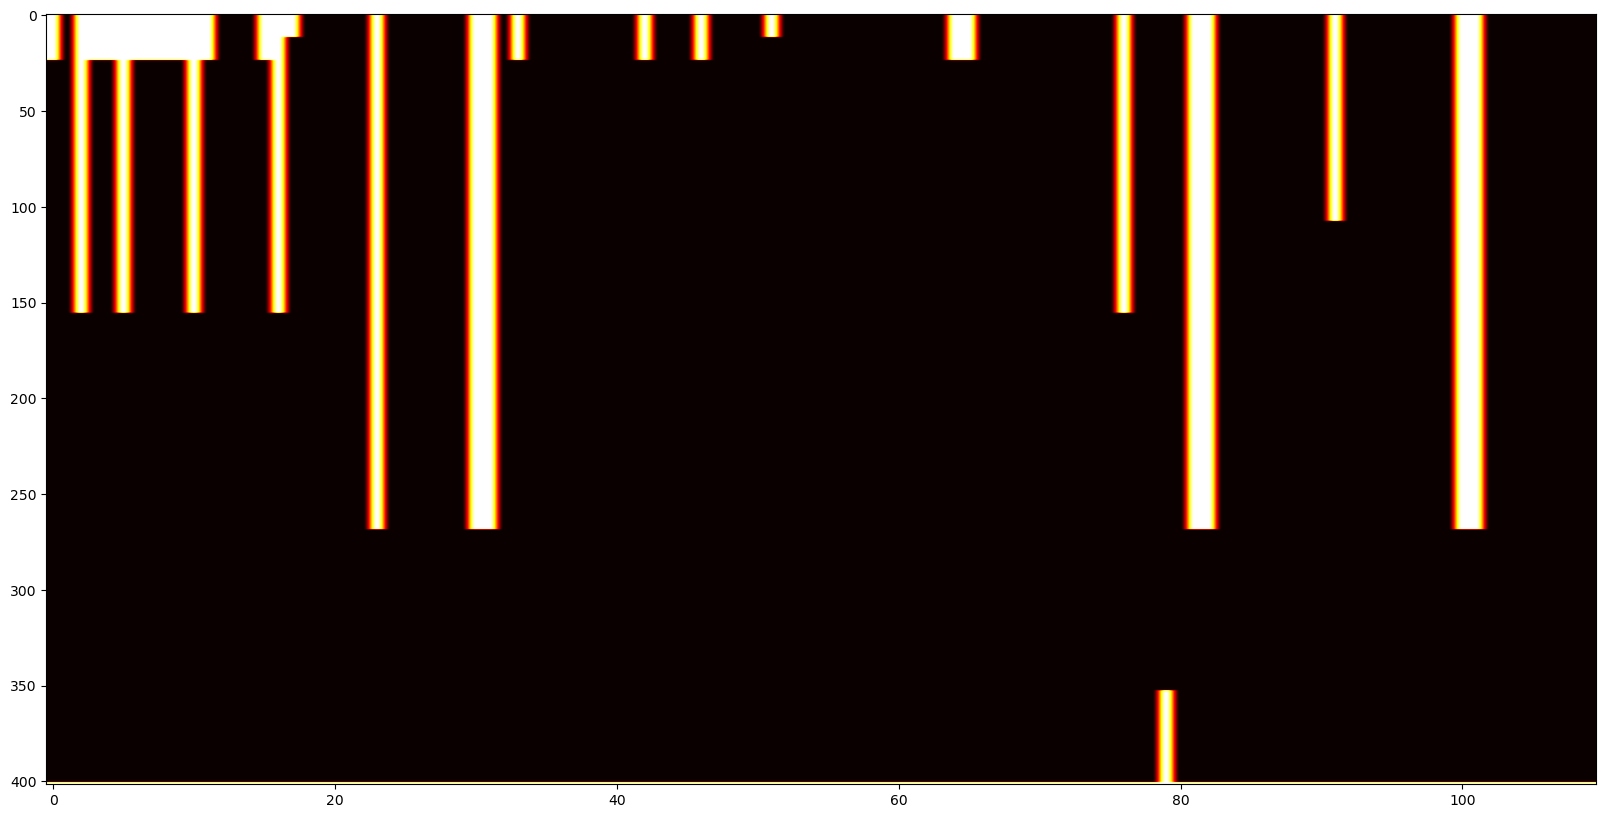

In [14]:
#visualize missing values
plt.rcParams["figure.figsize"] = (20, 10)
plt.imshow(df4.isnull(), cmap='hot', aspect='auto')
plt.show()

In [15]:
#Дропним пока колонки с missing values
df5 = df4.iloc[:-1]

In [16]:
df6 = df5.dropna(axis = 1)

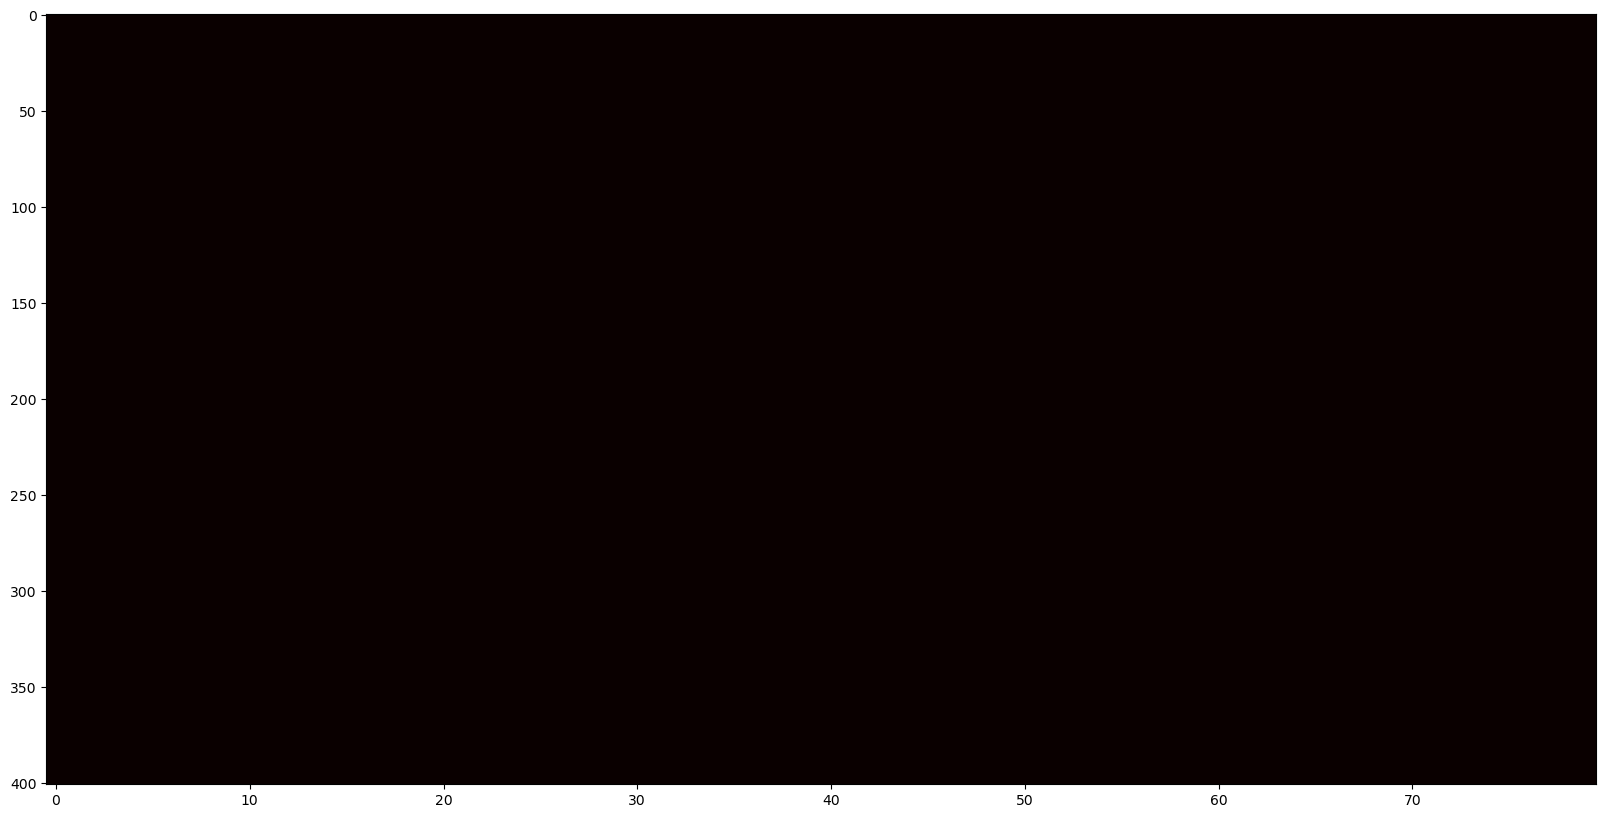

In [17]:
#visualize missing values
plt.rcParams["figure.figsize"] = (20, 10)
plt.imshow(df6.isnull(), cmap='hot', aspect='auto')
plt.show()

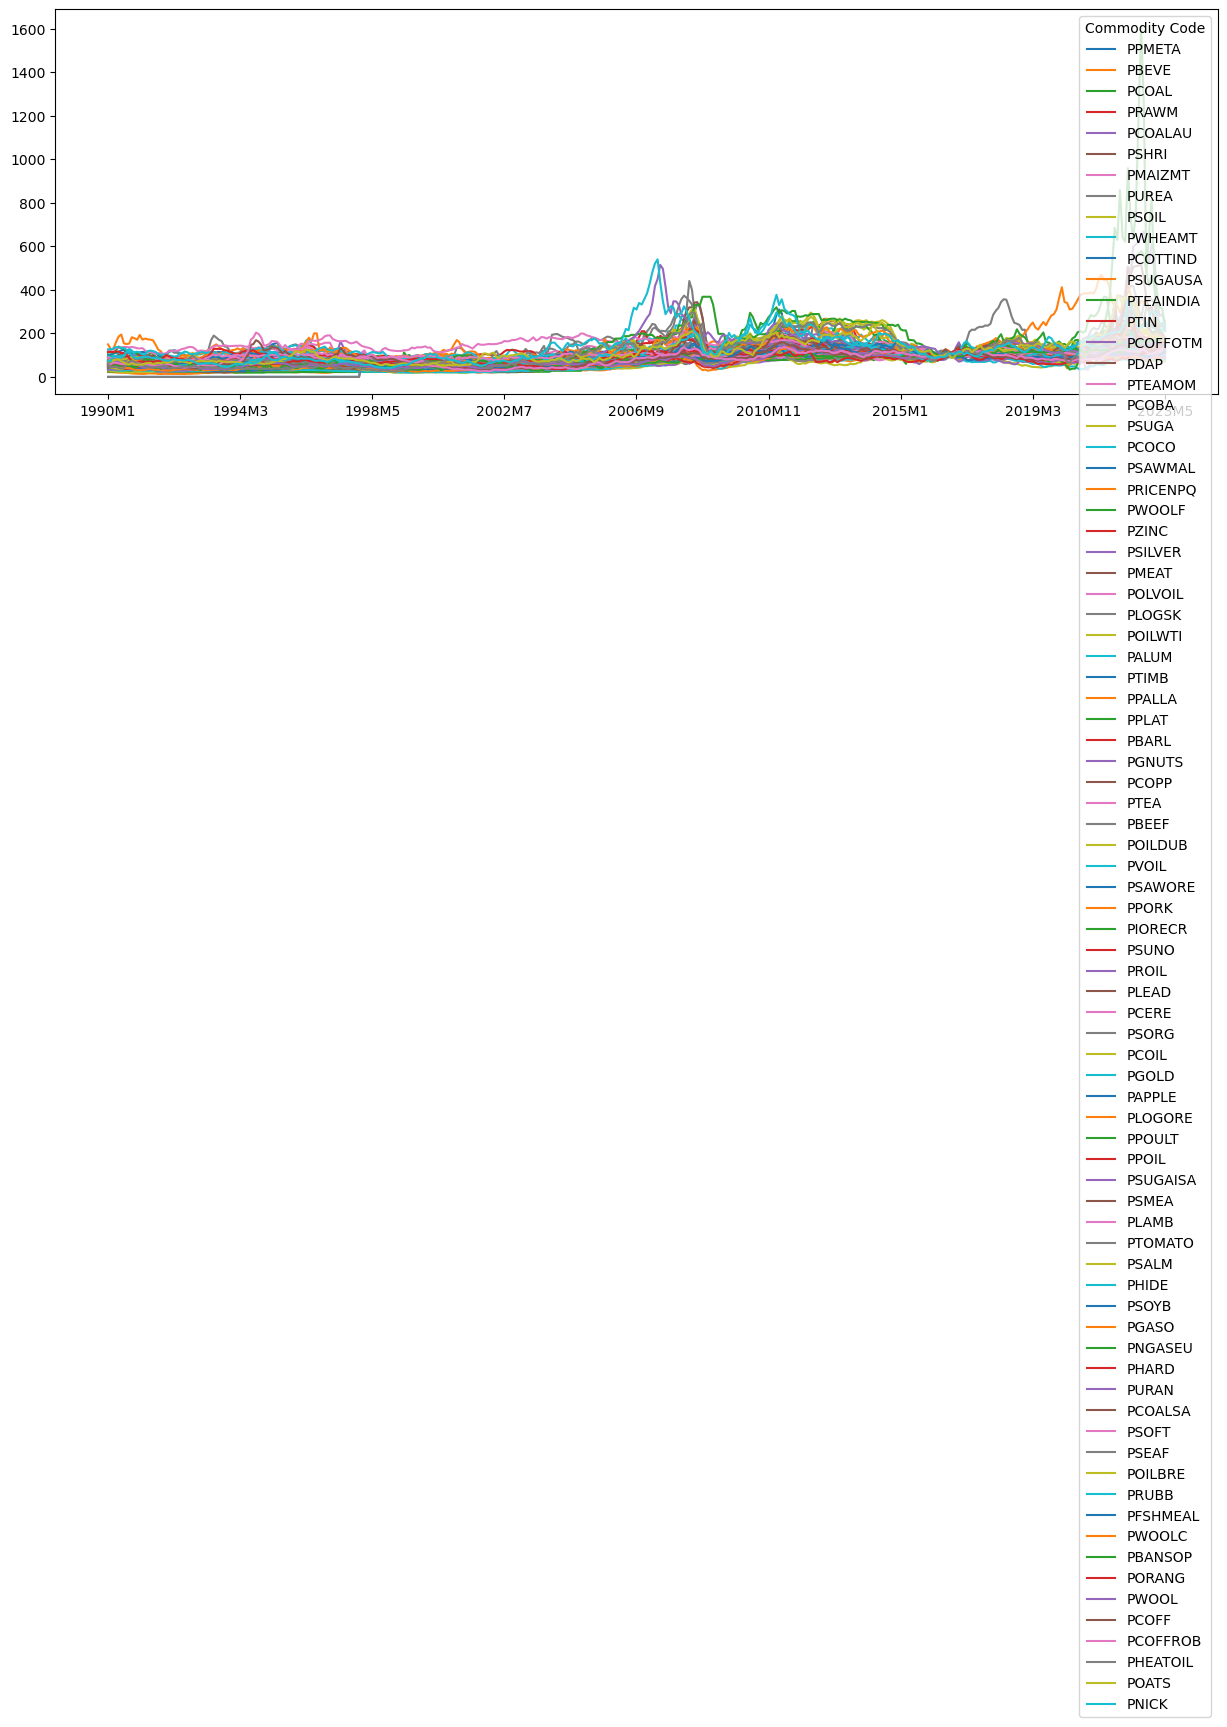

In [18]:
df6.plot(figsize=(15, 5));

In [19]:
df6.columns

Index(['PPMETA', 'PBEVE', 'PCOAL', 'PRAWM', 'PCOALAU', 'PSHRI', 'PMAIZMT',
       'PUREA', 'PSOIL', 'PWHEAMT', 'PCOTTIND', 'PSUGAUSA', 'PTEAINDIA',
       'PTIN', 'PCOFFOTM', 'PDAP', 'PTEAMOM', 'PCOBA', 'PSUGA', 'PCOCO',
       'PSAWMAL', 'PRICENPQ', 'PWOOLF', 'PZINC', 'PSILVER', 'PMEAT', 'POLVOIL',
       'PLOGSK', 'POILWTI', 'PALUM', 'PTIMB', 'PPALLA', 'PPLAT', 'PBARL',
       'PGNUTS', 'PCOPP', 'PTEA', 'PBEEF', 'POILDUB', 'PVOIL', 'PSAWORE',
       'PPORK', 'PIORECR', 'PSUNO', 'PROIL', 'PLEAD', 'PCERE', 'PSORG',
       'PCOIL', 'PGOLD', 'PAPPLE', 'PLOGORE', 'PPOULT', 'PPOIL', 'PSUGAISA',
       'PSMEA', 'PLAMB', 'PTOMATO', 'PSALM', 'PHIDE', 'PSOYB', 'PGASO',
       'PNGASEU', 'PHARD', 'PURAN', 'PCOALSA', 'PSOFT', 'PSEAF', 'POILBRE',
       'PRUBB', 'PFSHMEAL', 'PWOOLC', 'PBANSOP', 'PORANG', 'PWOOL', 'PCOFF',
       'PCOFFROB', 'PHEATOIL', 'POATS', 'PNICK'],
      dtype='object', name='Commodity Code')

In [20]:
df7 = df6[[choose_com]]
df7[choose_com] = df7[choose_com].astype(float)

C:\Users\Viktor\AppData\Local\Temp\ipykernel_24444\3902980021.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7[choose_com] = df7[choose_com].astype(float)


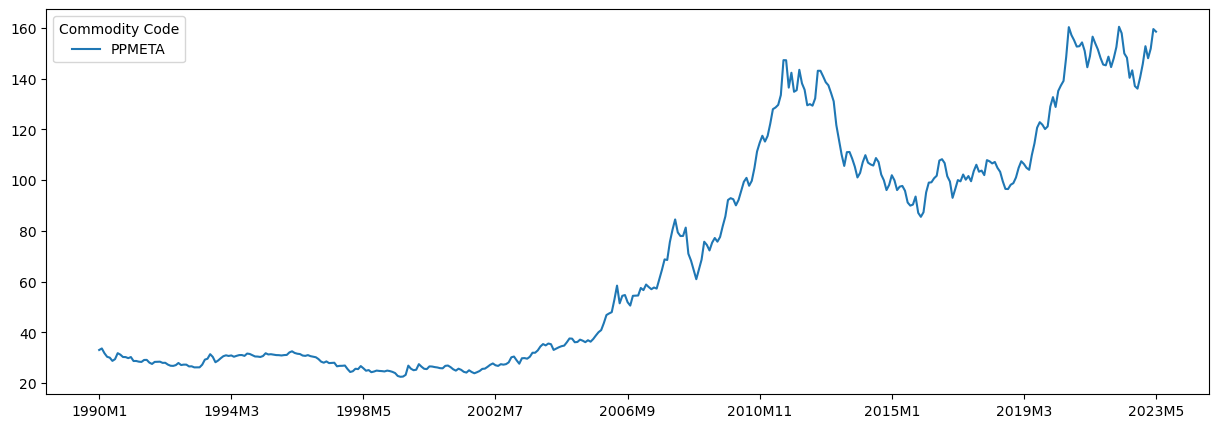

In [21]:
df7.plot(figsize=(15, 5));

In [22]:
from statsmodels.tsa.arima.model import ARIMA

#возьмем тест - 1 год

In [23]:
df7.index.freq = 'MS'

Ntest = 12
train = df7.iloc[:-Ntest]
test = df7.iloc[-Ntest:]

In [24]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401 entries, 1990M1 to 2023M5
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PPMETA  401 non-null    float64
dtypes: float64(1)
memory usage: 6.3+ KB


In [25]:
train_idx = df7.index <= train.index[-1]
test_idx = df7.index > train.index[-1]

In [26]:
arima = ARIMA(train[[choose_com]], order=(1,0,0))


C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [27]:
arima_result = arima.fit()

C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [28]:
df7.loc[train_idx, 'AR(1)'] = arima_result.predict(
    start=train.index[0], end=train.index[-1])

C:\Users\Viktor\AppData\Local\Temp\ipykernel_24444\236620759.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7.loc[train_idx, 'AR(1)'] = arima_result.predict(


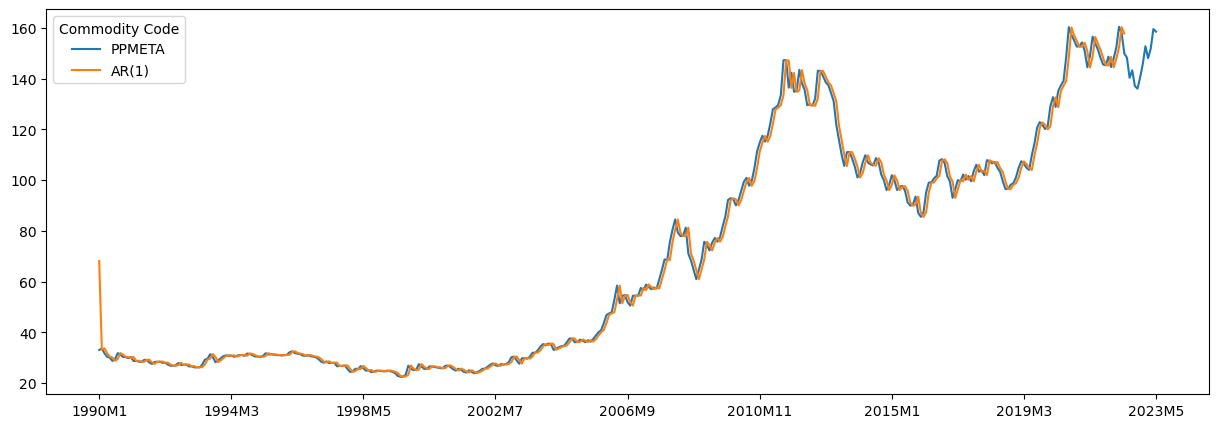

In [29]:
df7[[choose_com, 'AR(1)']].plot(figsize=(15, 5));

In [30]:
prediction_result = arima_result.get_forecast(Ntest)
forecast = prediction_result.predicted_mean
df7.loc[test_idx, 'AR(1)'] = forecast

C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Viktor\AppData\Local\Temp\ipykernel_24444\960043772.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7.loc[test_idx, 'AR(1)'] = forecast


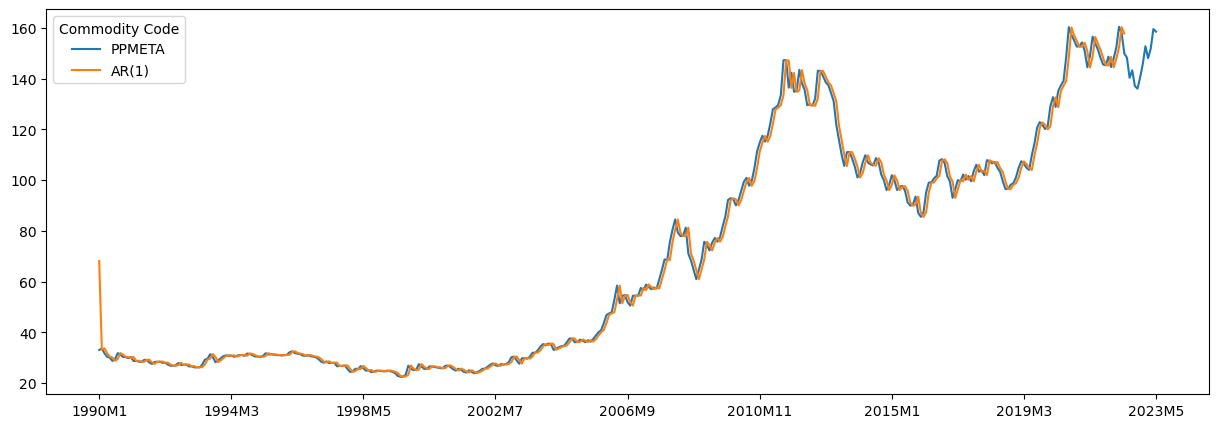

In [31]:
df7[[choose_com, 'AR(1)']].plot(figsize=(15, 5));

In [32]:
# Confidence interval
prediction_result.conf_int()

,lower PPMETA,upper PPMETA
389,144.034682,155.601293
390,141.535436,157.882162
391,139.596160,159.603354
392,137.947416,161.034306
393,136.484761,162.279460
394,135.154593,163.392418
395,133.925047,164.405044
396,132.775346,165.338114
397,131.691051,166.206070
398,130.661637,167.019432


In [33]:

def plot_fit_and_forecast(result):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(df7[choose_com], label='data')

  # plot the curve fitted on train set
    train_pred = result.fittedvalues
    ax.plot(train.index, train_pred, color='green', label='fitted')

  # forecast the test set
    prediction_result = result.get_forecast(Ntest)
    conf_int = prediction_result.conf_int()
    lower, upper = conf_int['lower ' + choose_com], conf_int['upper ' + choose_com]
    forecast = prediction_result.predicted_mean
    ax.plot(test.index, forecast, label='forecast')
    ax.fill_between(test.index, \
                  lower, upper, \
                  color='red', alpha=0.3)
    ax.legend()

C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


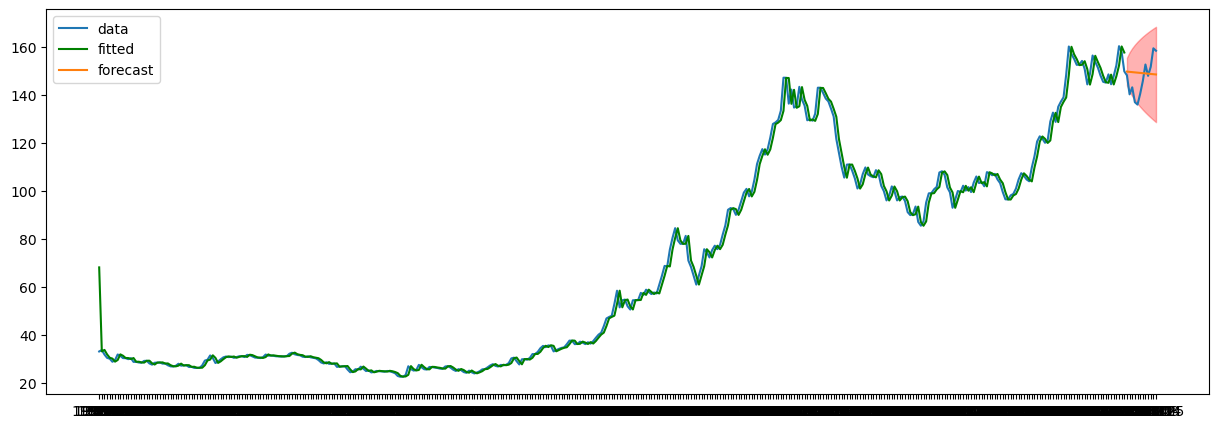

In [34]:

plot_fit_and_forecast(arima_result)

C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. 

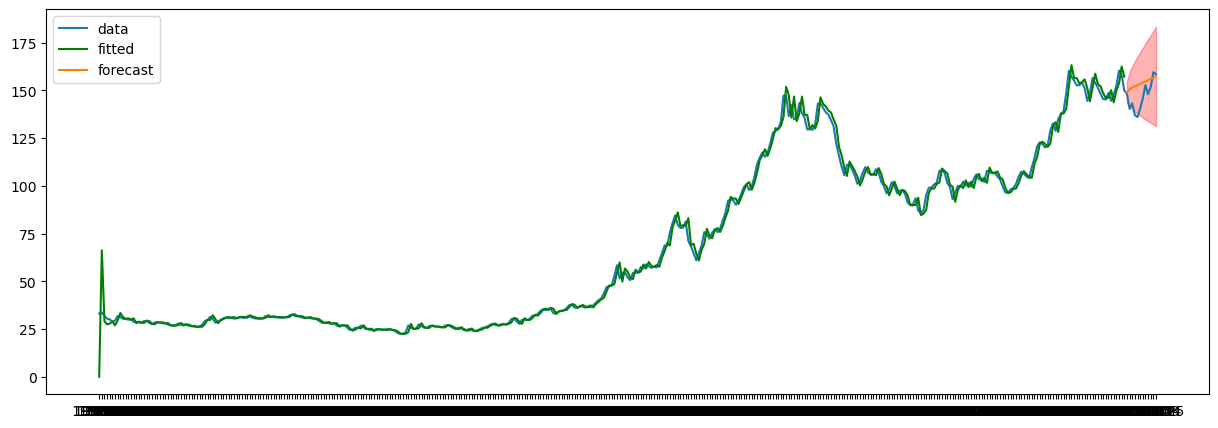

In [45]:

arima = ARIMA(train[choose_com], order=(2,3,2)) # AR(10)
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)

C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction result

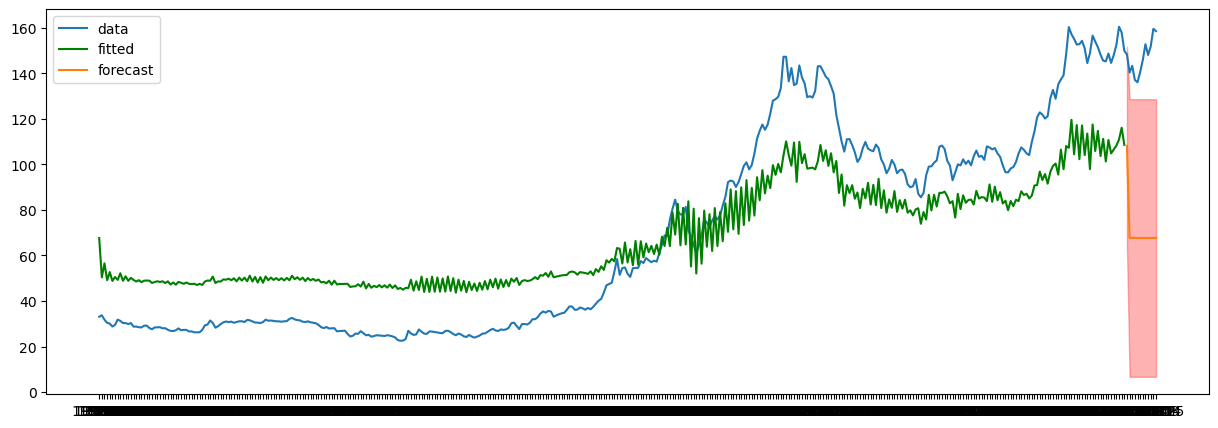

In [41]:
arima = ARIMA(train[choose_com], order=(0,0,1)) # MA(1)
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)

In [42]:
df7['Log' + choose_com] = np.log(df7[choose_com])

C:\Users\Viktor\AppData\Local\Temp\ipykernel_29840\465118920.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['Log' + choose_com] = np.log(df7[choose_com])


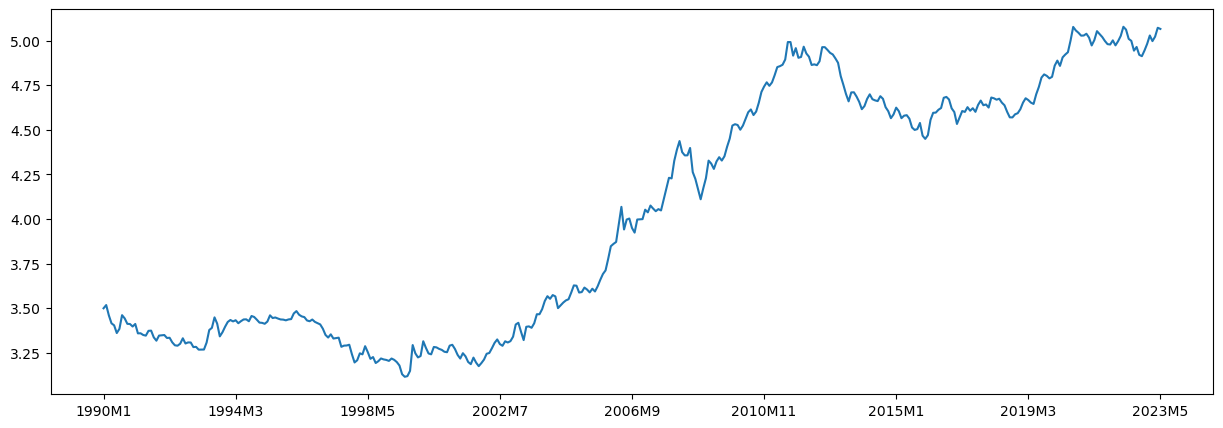

In [43]:
df7['Log' + choose_com].plot(figsize=(15, 5));

C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next v

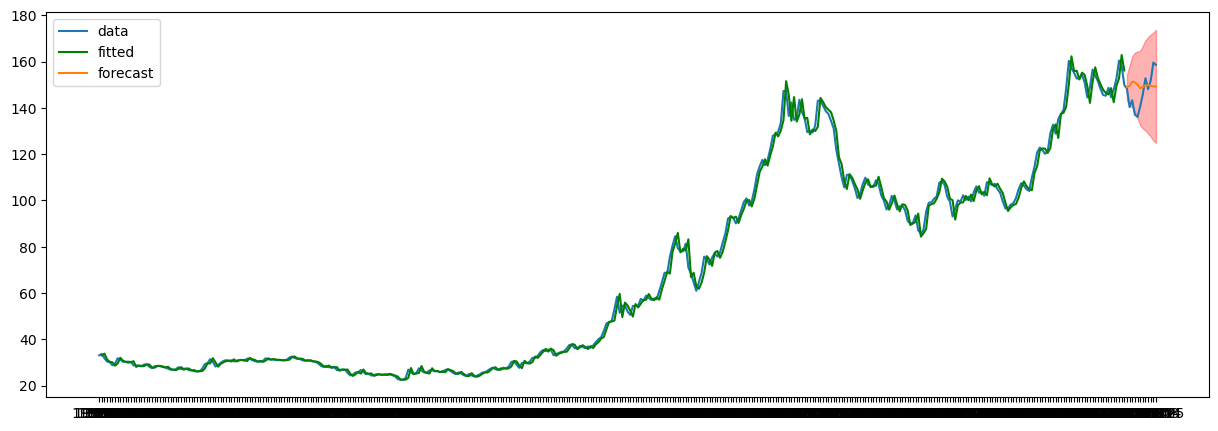

In [44]:
arima = ARIMA(train[choose_com], order=(8,1,1))
arima_result_811 = arima.fit()

def plot_fit_and_forecast_int(result, d, col=choose_com):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(df7[col], label='data')

  # plot the curve fitted on train set
    train_pred = result.predict(start=train.index[d], end=train.index[-1])

    ax.plot(train.index[d:], train_pred, color='green', label='fitted')

    # forecast the test set
    prediction_result = result.get_forecast(Ntest)
    conf_int = prediction_result.conf_int()
    lower, upper = conf_int[f'lower {col}'], conf_int[f'upper {col}']
    forecast = prediction_result.predicted_mean
    ax.plot(test.index, forecast, label='forecast')
    ax.fill_between(test.index, \
                  lower, upper, \
                  color='red', alpha=0.3)
    ax.legend()

plot_fit_and_forecast_int(arima_result_811, 1)

C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next v

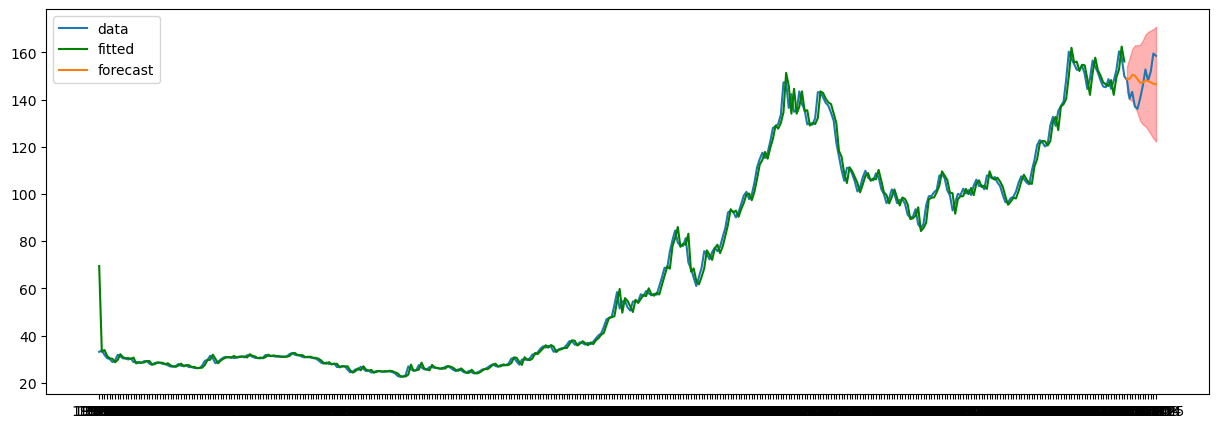

In [46]:

arima = ARIMA(train[choose_com], order=(10,0,0)) # AR(10)
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)